# Script for the Correction of differential scattering cross section in SAXS experiments (cooking book)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

URL for SAXS data of glassy carbon reference. There are several different onex available. The signal in high Q is nearly the same for all of them. Only in the low Q region they diverge from one another. The urls shown below correspond to the Glassy_Carbon_A, _B and _C samples from ANL. This script uses a Glassy carbon sample measured in another institute as reference.

Function to correct the thickness of the sample, by measuring an empty cuvette and one filled with water. For that two measurements with transmission and empty beam correspondingly have to be done with H2O and an empty cuvette. The mass attenuation coefficient for water in room temperature is $\frac{\mu}{\rho}=10.37\frac{cm²}{g}$. The sample thickness d can then be calculated by using:
\vspace{3mm}

$$d = -\rho_{H_2O}\frac{\rho}{\mu}ln\left(\frac{T_{H_2O+cell}}{T_{cell}}\right)$$

\vspace{3mm}
, with T being the transmission factors for an empty cell and water and $\rho_{H_2O}=1\frac{g}{cm²}$.

In [2]:
# Übergabe: 
#    - Transmissionfactor water+cell T_wc
#    - only cell T_c 
#    - Anode type, most of the time copper


def calc_d(T_wc,T_c,typ='copper'):
    
    if typ=='copper':
        MAC_w = 10.37 #cm²/g, for copper anode
        
    rho_w = 1 #g/cm³
    
    d = -np.log(T_wc/T_c)*1/(MAC_w*rho_w) #cm
    return(d)

%display latex
Function to calculate the transmission factor for intensity of sample S and empty beam intensity $I_0$:
\vspace{3mm}
$$T_S=\frac{I_S}{I_0}$$

In [3]:
def calc_T(I_S,I_0):
    return(I_S/I_0)

This Function calulates the Scaling or Correction Factor with a Glassy Carbon measurement done in your setup and scales it so it fits the intensity of the 'Glassy-Carbon-A' sample from ANL. You can chose whatever reference sample you like. They should turn out more or less the same. For consistency's sake, I will solely use the A sample. The formula for the SF calculation follows from Fan-Paper:
\vspace{3mm}
$$SF = \frac{\left(\frac{\delta\Sigma}{\delta\Omega}\right)_{ref}}{\frac{(I_{GC})}{d_{GC}t_{GC}T_{GC}}}$$
\vspace{3mm}
,with 'st' corresponding to the standard sample, in my case glassy carbon. BG corresponds to the background measurement and T the transmission factor for the GC measurements.

In [24]:
# Übergabe: 
#    - Intensity of GC
#    - Q values of measurement for interpolation from Reference sample
#    - Background of GC measurement
#    - Transmissionfactor GC
#    - thickness sample d_GC


def calc_SF(I_GC,Q_GC,T_GC,d_GC,t_GC,plot=False):
    
    
    from scipy.optimize import curve_fit as fit
    def fit_lin(x,a,c):
        return np.exp(a*np.log10(x)+c)

    import os 
    #correct this line for the path in which the GC reference is located
    sample_GCA = np.loadtxt(r'C:\Users\ZechT\FAUbox\Betreuung\ILS\WS2020-21_SAXS-Praktikum\Gruppen\Gruppe4/GC_APS.txt')
    # in this line the linear fits at low Q values are made for the GC measurement and reference
    DSC_GC = fit(fit_lin,Q_GC[:6],I_GC[:6]/(d_GC*t_GC*T_GC))[0]
    DSC_Ref = fit(fit_lin,sample_GCA[:35,0],sample_GCA[:35,1])[0]
    print('Fit Params. Meas: ',np.exp(DSC_GC), ' Fit Params. Ref: ',np.exp(DSC_Ref))
    # the scaling factor is calculated 
    SF = np.exp(DSC_Ref[1])/(np.exp(DSC_GC[1]))
    print(SF)
    #SF = np.mean(SF)

    return(SF, DSC_GC, DSC_Ref)     

Finally the differential scattering crosssection for sample s will be correctly calculated using all previously determined parameters $SF$ and $d_s$:
\vspace{3mm}
$$\left(\frac{\delta\Sigma}{\delta\Omega}\right)_s(q) = SF \left(\frac{I_s(q)}{d_s t_sT_s}-\frac{BG_s(q)}{d_{BG}t_{BG}T_{BG}}\right)$$

In [25]:
# Übergabe: 
#    - Intensity of sample
#    - Background of sample measurement
#    - Transmissionfactor GC
#    - thickness sample d_GC
#    - Scaling factor
# WARNING: Use this formula only, if the BG (water) absolutcorrection (multiplied by SF and 
# divide by (t_BG*T_BG*d_BG)) has already been applied!!!
def calc_diffScatCross(I_s,BG_s,T_sc,d_s,t_s,SF):
    return(SF*(I_s)/(d_s*t_s*T_s)-BG_s)

# From here on follows an example

From here follows an example using sample TiS710 and data measured on our Anton Paar machine. First the intensities are extracted from .stat files. This process will not be discussed further, because it's simply parsing the files contained in the in 'dir' specified folder automatically. This step corresponds to  <span class="girk">point (1)</span> in the cooking book. Calculate the transmission factors. (You have calculated the Transmission by hand via Fit2D. You can therefore ignore the following code section. Important is only the following table in which all the transmission values for the data that is relevant in the following correction steps.)

In [26]:
import os

dir = r'C:\Users\ZechT\FAUbox\Auswertung\Software\ICSPy\compute\SAXS\test_data\\'

l_EB_Stats = []
l_TR_Stats = []

table = pd.DataFrame(columns = ['TR','EB','I_TR','I_EB','T'])
pairs = pd.DataFrame(columns = ['typ','samp'])

for iFile in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, iFile)):
        if '.stat' in iFile:
            enum = iFile.split('_')[0]
            typ = iFile.split('_')[2]
            samp = iFile.split('_')[1]
            pairs.loc[str(enum)] = [str(typ),str(samp)]

for iFile in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, iFile)):
        #print(os.path.join(dir,iFile))
        if '.stat' in iFile:
            for line in open(os.path.join(dir,iFile),'r'):
                if 'Total intensity' in line:
                    inty = line.split()[3]
                    enum = iFile.split('_')[0]
                    samp = pairs.loc[str(enum),'samp']
                    typ = pairs.loc[str(enum),'typ']
                    if str(samp) not in table.index:
                        table.loc[str(samp)] = [0,0,0,0,0]
                    if typ == 'TR':
                        table.loc[str(samp),'TR'] = enum
                        table.loc[str(samp),'I_TR'] = inty
                    elif typ == 'EB' or 'DB':
                        table.loc[str(samp),'EB'] = enum
                        table.loc[str(samp),'I_EB'] = inty
                    
for iInd in table.index:
    table.loc[iInd,'T'] = calc_T(float(table.loc[iInd,'I_TR']),float(table.loc[iInd,'I_EB']))
    
table

,TR,EB,I_TR,I_EB,T
GC,01724,01723,3.75920E+05,7.01408E+05,0.535951
SGNR,01727,01728,2.11857E+05,7.99840E+05,0.264874
H2O,01744,01743,1.45425E+05,5.66515E+05,0.256701
EC,01746,01747,3.65022E+05,5.57136E+05,0.655176



In the next step the SF will be determined via the glassy carbon measurement. This is <span class="girk">step (2)</span>.

Fit Params. Meas:  [0.72063473 8.97660892]  Fit Params. Ref:  [ 0.74103272 28.43637373]
3.1678302992298346


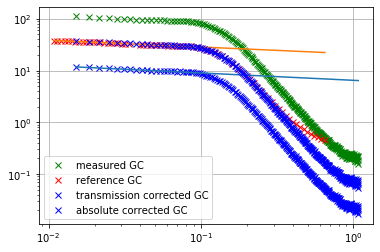

calculated scaling factor SF = 3.1678302992298346


In [27]:
#data_GC = np.loadtxt(r'C:\Users\ZechT\FAUbox\Betreuung\ILS\WS2020-21_SAXS-Praktikum\Gruppen\Gruppe4\SAXS/7917_gc_reduced.pdh')
sample_GCA = np.loadtxt(r'C:\Users\ZechT\FAUbox\Betreuung\ILS\WS2020-21_SAXS-Praktikum\Gruppen\Gruppe4/GC_APS.txt')
data_GC = np.loadtxt(r'C:\Users\ZechT\FAUbox\Betreuung\ILS\WS2020-21_SAXS-Praktikum\Gruppen\Gruppe4\SAXS/7917_gc_reduced.pdh',skiprows=5,max_rows=332)

#data_GC[:,0] /= 10.0
plt.figure()
plt.loglog(data_GC[:,0]/10,data_GC[:,1],'xg', label='measured GC')
plt.loglog(sample_GCA[:,0]/10,sample_GCA[:,1],'xr',label='reference GC')

def fit_lin(x,a,c):
    return np.exp(a*np.log10(x)+c)

data_BG_GC = np.zeros(shape=(len(data_GC[:,0])))
SF,Line_GC,Line_Ref = calc_SF(I_GC=data_GC[:,1],
             t_GC=180,
             Q_GC=data_GC[:,0],
             T_GC=0.522,#table.loc['GC','T'],
             d_GC=0.1)
d_GC=0.1 #cm
T_GC=0.522#table.loc['GC','T']
t_GC=180 #s
plt.loglog(data_GC[:,0]/10,data_GC[:,1]/(d_GC*t_GC*T_GC),'xb',label='transmission corrected GC')
plt.loglog(data_GC[:,0]/10,fit_lin(data_GC[:,0],Line_GC[0],Line_GC[1]))
plt.loglog(sample_GCA[:,0]/10,fit_lin(sample_GCA[:,0],Line_Ref[0],Line_Ref[1]))
plt.loglog(data_GC[:,0]/10,data_GC[:,1]/(d_GC*t_GC*T_GC)*SF,'xb',label='absolute corrected GC')
plt.legend(loc='best')
plt.grid()
plt.show()
print('calculated scaling factor SF = ' +str(SF))

In <span class="girk">step (3)</span>  the thickness of the samples will be calculated from H2O and empty cell measurements.

In [18]:
T_wc = table.loc['H2O','T']
T_c = table.loc['EC','T']

d_s = calc_d(T_wc=T_wc,T_c=T_c)
print('thickness of sample d_s = %f01 ; (should be about 0.1 cm)' % d_s)

thickness of sample d_s = 0.09035601 ; (should be about 0.1 cm)


In the end of this procedure (<span class="girk">step (4)</span>) the differential scattering cross section of the sample will be calculated, by using the parameters determined in the steps above.

In [20]:
T_s = table.loc['SGNR','T']
T_BG = table.loc['H2O','T']

data_s = np.loadtxt(r'C:\Users\ZechT\FAUbox\Auswertung\Software\ICSPy\compute\SAXS\test_data/01725_S_GNR.chi')
data_H2O = np.loadtxt(r'C:\Users\ZechT\FAUbox\Auswertung\Software\ICSPy\compute\SAXS\test_data/01745_H2O.chi')

I_s = data_s[:,1]
BG_s = data_H2O[:,1]

t_s = 3600
t_BG = 3600

d_BG = float(d_s)

DSC_s = SF*(I_s/(d_s*T_s*t_s)-BG_s/(t_BG*T_BG*d_BG))

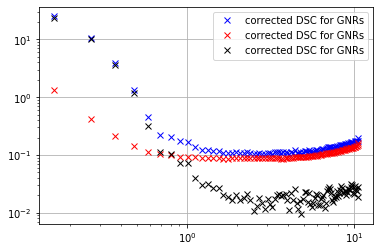

In [23]:
plt.loglog(data_s[:,0],data_s[:,1],'xb',label='corrected DSC for GNRs');
plt.loglog(data_H2O[:,0],data_H2O[:,1],'xr',label='corrected DSC for GNRs');
plt.loglog(data_s[:,0],DSC_s,'xk',label='corrected DSC for GNRs');
plt.legend()
plt.grid()
plt.show()